In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-quality/apple_quality.csv


In [2]:
import torch
from torch import nn
from torch.nn import functional as F

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.dense1 = nn.Linear(7, 40, device=device)
        self.sigmoid1 = nn.Sigmoid()
        self.dropout1 = nn.Dropout(p=0.3)
        self.dense2 = nn.Linear(40, 50, device=device)
        self.sigmoid2 = nn.Sigmoid()
        self.dropout2 = nn.Dropout(p=0.3)
        self.dense3 = nn.Linear(50, 30, device=device)
        self.sigmoid3 = nn.Sigmoid()
        self.dropout3 = nn.Dropout(p=0.3)
        self.dense4 = nn.Linear(30, 1, device=device)
#         self.sigmoid4 = nn.Sigmoid()
        
        print(f'Dense1 type: {self.dense1.weight.dtype}')
        print(f'Dense2 type: {self.dense2.weight.dtype}')
        print(f'Dense3 type: {self.dense3.weight.dtype}')
        print(f'Dense4 type: {self.dense4.weight.dtype}')
        
        
    def forward(self, x):
        out1 = self.dropout1(self.sigmoid1(self.dense1(x)))
        out2 = self.dropout2(self.sigmoid2(self.dense2(out1)))
        out3 = self.dropout3(self.sigmoid3(self.dense3(out2)))
        output = self.dense4(out3)
        return output
        

In [4]:
def shuffle_two_arrays(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [5]:
train_split = 0.7
validation_split = 0.2
test_split = 0.1

In [6]:
file_name = '/kaggle/input/apple-quality/apple_quality.csv'

In [7]:
data = pd.read_csv(file_name)

In [8]:
data = data.dropna()

In [9]:
data = data.drop('A_id', axis=1)

In [10]:
data = data.replace({'Quality':{'good': 1, 'bad':0}})

/tmp/ipykernel_26/3540022417.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'Quality':{'good': 1, 'bad':0}})


In [11]:
X_data = data.loc[:,data.columns != 'Quality']

In [12]:
X_data

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036
...,...,...,...,...,...,...,...
3995,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784369
3996,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285
3997,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391
3998,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806


In [13]:
Y_data = data.loc[:, 'Quality']

In [14]:
Y_data

0       1
1       1
2       0
3       1
4       1
       ..
3995    0
3996    1
3997    0
3998    1
3999    1
Name: Quality, Length: 4000, dtype: int64

In [15]:
X_data = X_data.to_numpy()

In [16]:
Y_data = Y_data.to_numpy()

In [17]:
X_data, Y_data = shuffle_two_arrays(X_data, Y_data)

In [18]:
X_train = X_data[:int(train_split*len(X_data))].astype(np.double)
Y_train = Y_data[:int(train_split*len(Y_data))].astype(np.double)
X_val = X_data[int(train_split*len(X_data)):int((train_split+validation_split)*len(X_data))].astype(np.double)
Y_val = Y_data[int(train_split*len(X_data)):int((train_split+validation_split)*len(Y_data))].astype(np.double)
X_test = X_data[int((train_split+validation_split)*len(X_data)):].astype(np.double)
Y_test = Y_data[int((train_split+validation_split)*len(X_data)):].astype(np.double)

In [19]:
Xtrain = torch.from_numpy(X_train)
Ytrain = torch.from_numpy(Y_train)
Xval = torch.from_numpy(X_val)
Yval = torch.from_numpy(Y_val)
Xtest = torch.from_numpy(X_test)
Ytest = torch.from_numpy(Y_test)

In [20]:
dtype = torch.float32
Xtrain = Xtrain.to(dtype)
Ytrain = Ytrain.to(dtype)
Xval = Xval.to(dtype)
Yval = Yval.to(dtype)
Xtest = Xtest.to(dtype)
Ytest = Ytest.to(dtype)

In [21]:
model = Model()

Dense1 type: torch.float32
Dense2 type: torch.float32
Dense3 type: torch.float32
Dense4 type: torch.float32


In [22]:
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001)
loss = torch.nn.BCEWithLogitsLoss()

In [23]:
def train(model, inputs, targets, loss, optimizer, device):
    model.train()
    
    X = torch.autograd.Variable(inputs, requires_grad=False)
    Y = torch.autograd.Variable(targets, requires_grad=False)
    Y = Y.unsqueeze(1)
    
    optimizer.zero_grad()
    logits = model.forward(X)
    output = loss.forward(logits, Y)
    output.backward()
    optimizer.step()
    return output.item()

In [24]:
def validate(model, inputs, targets, loss, device):
    model.eval()
    
    X = torch.autograd.Variable(inputs, requires_grad=False)
    Y = torch.autograd.Variable(targets, requires_grad=False)
    Y = Y.unsqueeze(1)
    
    logits = model.forward(X)
    output = loss.forward(logits, Y)
    
    pred = torch.nn.Sigmoid()(logits)
    
    predictions = torch.eq(torch.round(pred), Y)
    accuracy = sum(predictions) / len(predictions)
    
    return output.item(), accuracy

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
Xtrain = Xtrain.to(device)
Ytrain = Ytrain.to(device)
Xval = Xval.to(device)
Yval = Yval.to(device)
Xtest = Xtest.to(device)
Ytest = Ytest.to(device)
epochs = 20_000

losses = []
validation_losses = []

for epoch in range(epochs):
    output = train(model, Xtrain, Ytrain, loss, optimizer, device)
    losses.append(output)
    if epoch % 1000 == 0:
        validation_output, accuracy = validate(model, Xval, Yval, loss, device)
        validation_losses.append(validation_output)
        print(f'Epoch {epoch}, train_loss: {output}, validation_loss: {validation_output}, accuracy: {accuracy[0]}')

Epoch 0, train_loss: 0.7113293409347534, validation_loss: 0.6987513303756714, accuracy: 0.5118898749351501
Epoch 1000, train_loss: 0.3773813247680664, validation_loss: 0.3308981657028198, accuracy: 0.8585732579231262
Epoch 2000, train_loss: 0.2944902181625366, validation_loss: 0.2577652633190155, accuracy: 0.8948686122894287
Epoch 3000, train_loss: 0.25525936484336853, validation_loss: 0.21116098761558533, accuracy: 0.9211514592170715
Epoch 4000, train_loss: 0.22519038617610931, validation_loss: 0.18594425916671753, accuracy: 0.9261577129364014
Epoch 5000, train_loss: 0.2127029448747635, validation_loss: 0.16991187632083893, accuracy: 0.9261577129364014
Epoch 6000, train_loss: 0.1863340586423874, validation_loss: 0.15844210982322693, accuracy: 0.9349186420440674
Epoch 7000, train_loss: 0.18202880024909973, validation_loss: 0.14827817678451538, accuracy: 0.9411764740943909
Epoch 8000, train_loss: 0.17014098167419434, validation_loss: 0.14442503452301025, accuracy: 0.9461827278137207
Epo

In [26]:
import matplotlib.pyplot as plt

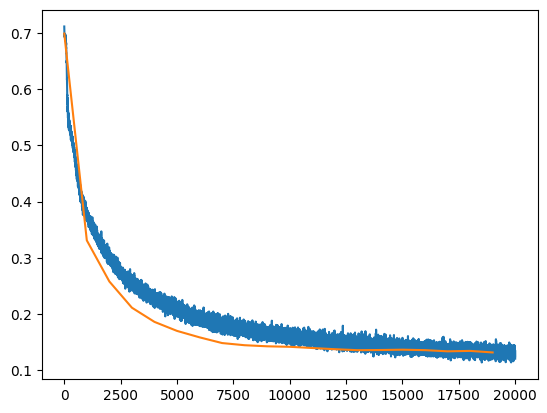

In [27]:
plt.plot(losses)
plt.plot(range(0, epochs, 1000), validation_losses)

In [28]:
def test(model, inputs, targets):
    model.eval()
    
    X = torch.autograd.Variable(inputs, requires_grad=False)
    Y = torch.autograd.Variable(targets, requires_grad=False)
    Y = Y.unsqueeze(1)
    
    logits = model.forward(X)    
    pred = torch.nn.Sigmoid()(logits)
    predictions = torch.eq(torch.round(pred), Y)
    accuracy = sum(predictions) / len(predictions)
    
    return accuracy.item()

In [29]:
test_accuracy = test(model, Xtest, Ytest)
print(test_accuracy)

0.9276808500289917
